# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e7d7325618484fe6934a49d1a05ade9e/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm
import json

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)
#with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
#    topo = xr.open_dataset(fp)

In [5]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [6]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [7]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [8]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [9]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

In [10]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

In [11]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

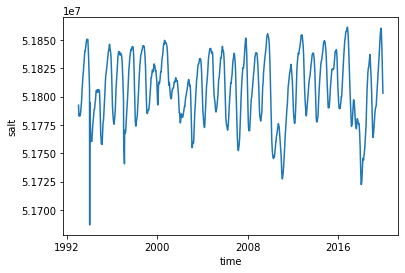

In [12]:
ds_wg.salt.sum(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()

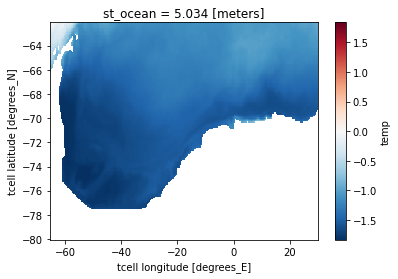

In [13]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).sel(time=slice('1997-02-15', '2019')).mean(dim='time')
sst_mean.plot()

## <span style='color:Red'> Bottom Potential Temperatures

In [14]:
#999 is ocean, 111 is land
hfacc = ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull(), 999).where(ds_wg.temp < 999, 111)

In [15]:
hfacc

,Array,Chunk
Bytes,23.63 GiB,12.28 MiB
Shape,"(1970, 50, 169, 381)","(1, 50, 169, 381)"
Count,21677 Tasks,1970 Chunks
Type,float32,numpy.ndarray


In [16]:
#999 is ocean, 111 is land
depth_max = (ds_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

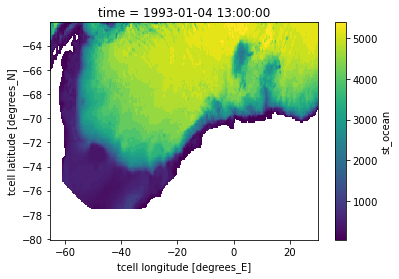

In [17]:
depth_max[0].plot()

In [ ]:
depth_surf = (ds_wg.st_ocean.where(hfacc == 999)).min(dim='st_ocean').load()

In [ ]:
depth_surf[0].plot()

In [ ]:
hfacc_file = depth_surf.to_dataset(name='hfacc')

In [ ]:
hfacc_file

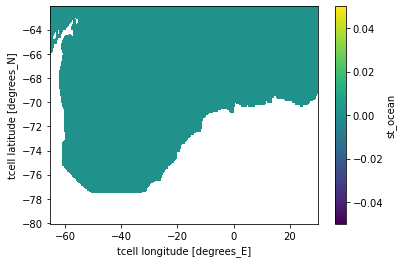

In [18]:
#depth doesn't change in time
depth_max.std(dim='time').plot()

In [19]:
depth_max = depth_max[0]

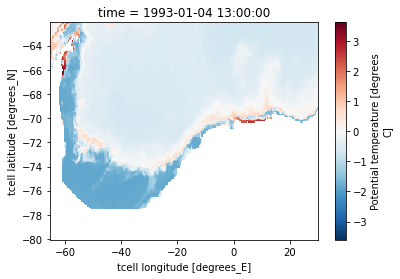

In [20]:
ds_wg.temp[0].sel(st_ocean=depth_max, method='nearest').plot()

In [21]:
temp_mean = ds_wg.temp.mean(dim='time').load()

In [22]:
temp_mean

<xarray.DataArray 'temp' (st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-2.3480412e-03,  1.0349037e-02,  1.7162800e-02, ...,
         -9.2941266e-01, -9.3249160e-01, -9.3297869e-01],
        [ 4.1074377e-02,  5.4369219e-02,  6.0438003e-02, ...,
         -9.1982865e-01, -9.2092437e-01, -9.2131364e-01],
        [ 8.6172298e-02,  9.7879276e-02,  1.0314330e-01, ...,
         -9.1091442e-01, -9.1068417e-01, -9.0824276e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [           nan,            nan,            nan, ...,
         -5.5190450e-01, -5.5108154e-01, -5.4997754e-01],
        [           nan,            nan,            nan, ...,
         -5.5275756e-01, -5.5211669e-01, -5.5140436e-01],
        [           nan,            nan,            nan, ...,
         -5.5365908e-01, -5.5357212e-01, -5.5376202e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [23]:
temp_mean.sel(st_ocean=depth_max, method='nearest')

<xarray.DataArray 'temp' (yt_ocean: 169, xt_ocean: 381)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.3852743 ,  0.38618386,  0.38927206, ..., -0.5519045 ,
        -0.55108154, -0.54997754],
       [ 0.3911812 ,  0.3939399 ,  0.46547386, ..., -0.55275756,
        -0.5521167 , -0.55140436],
       [ 0.39906168,  0.4294568 ,  0.4476148 , ..., -0.5536591 ,
        -0.5535721 , -0.553762  ]], dtype=float32)
Coordinates:
    st_ocean  (yt_ocean, xt_ocean) float64 5.395e+03 5.395e+03 ... 5.185e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    time      object 1993-01-04 13:00:00

In [24]:
bottom_temp = temp_mean.sel(st_ocean=depth_max, method='nearest')

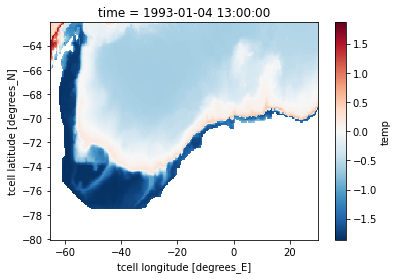

In [25]:
bottom_temp.plot()

In [26]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


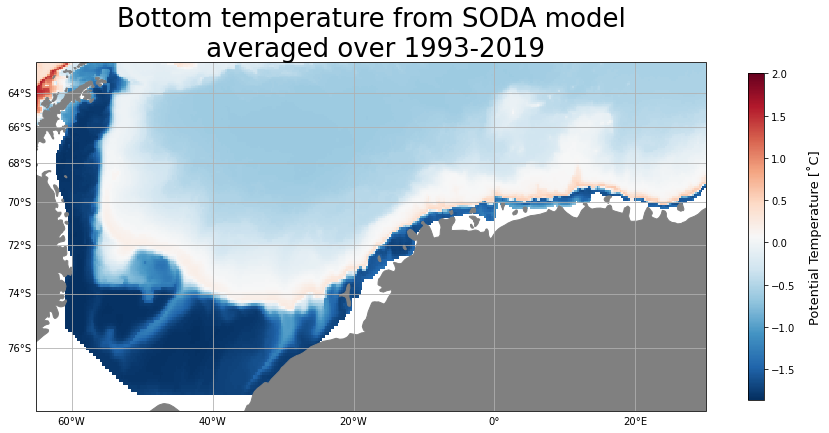

In [27]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SODA model\n averaged over 1993-2019', fontsize=26)
plt.savefig('bot-temp-soda.pdf');

In [28]:
bottom_temp

<xarray.DataArray 'temp' (yt_ocean: 169, xt_ocean: 381)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.3852743 ,  0.38618386,  0.38927206, ..., -0.5519045 ,
        -0.55108154, -0.54997754],
       [ 0.3911812 ,  0.3939399 ,  0.46547386, ..., -0.55275756,
        -0.5521167 , -0.55140436],
       [ 0.39906168,  0.4294568 ,  0.4476148 , ..., -0.5536591 ,
        -0.5535721 , -0.553762  ]], dtype=float32)
Coordinates:
    st_ocean  (yt_ocean, xt_ocean) float64 5.395e+03 5.395e+03 ... 5.185e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    time      object 1993-01-04 13:00:00

In [29]:
swap = bottom_temp.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [30]:
swap

<xarray.DataArray 'temp' (lat: 169, lon: 381)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.3852743 ,  0.38618386,  0.38927206, ..., -0.5519045 ,
        -0.55108154, -0.54997754],
       [ 0.3911812 ,  0.3939399 ,  0.46547386, ..., -0.55275756,
        -0.5521167 , -0.55140436],
       [ 0.39906168,  0.4294568 ,  0.4476148 , ..., -0.5536591 ,
        -0.5535721 , -0.553762  ]], dtype=float32)
Coordinates:
    st_ocean  (lat, lon) float64 5.395e+03 5.395e+03 ... 5.185e+03 5.185e+03
    xt_ocean  (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
    yt_ocean  (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
    time      object 1993-01-04 13:00:00
Dimensions without coordinates: lat, lon

In [31]:
swap.xt_ocean

<xarray.DataArray 'xt_ocean' (lon: 381)>
array([-65.125, -64.875, -64.625, ...,  29.375,  29.625,  29.875])
Coordinates:
    xt_ocean  (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
    time      object 1993-01-04 13:00:00
Dimensions without coordinates: lon
Attributes:
    cartesian_axis:  X
    long_name:       tcell longitude
    units:           degrees_E

In [32]:
bottom_temp = swap.assign_coords({"lon": swap.xt_ocean.values, 'lat':swap.yt_ocean}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

In [33]:
bottom_temp

<xarray.DataArray 'temp' (lat: 169, lon: 381)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.3852743 ,  0.38618386,  0.38927206, ..., -0.5519045 ,
        -0.55108154, -0.54997754],
       [ 0.3911812 ,  0.3939399 ,  0.46547386, ..., -0.55275756,
        -0.5521167 , -0.55140436],
       [ 0.39906168,  0.4294568 ,  0.4476148 , ..., -0.5536591 ,
        -0.5535721 , -0.553762  ]], dtype=float32)
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [34]:
bottom_temp.to_netcdf('bottom_temp.nc', mode='w')

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [35]:
temp_std = ds_wg.temp.std(dim='time').load()

In [36]:
bottom_temp_std = temp_std.sel(st_ocean=depth_max, method='nearest')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


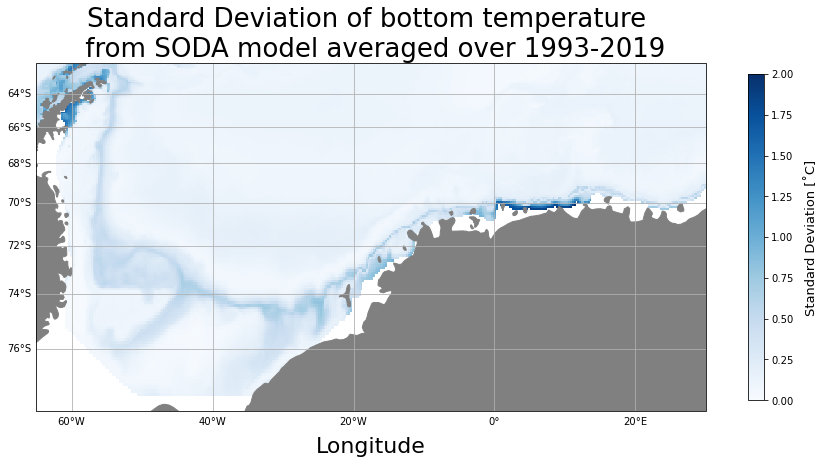

In [37]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp_std, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)

plt.title('Standard Deviation of bottom temperature \n from SODA model averaged over 1993-2019', fontsize=26)
plt.savefig('std-bot-temp-soda.pdf');

In [38]:
swap_dim = bottom_temp_std.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [39]:
bottom_temp_std = swap_dim.assign_coords({"lon": swap_dim.xt_ocean.values, 
                                          'lat':swap_dim.yt_ocean.values}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

In [40]:
bottom_temp_std

<xarray.DataArray 'temp' (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.12278862, 0.12426041, 0.1233142 , ..., 0.09295084, 0.09375399,
        0.09471092],
       [0.11924453, 0.12078746, 0.13167919, ..., 0.09136298, 0.09170933,
        0.09243467],
       [0.11351789, 0.11853682, 0.12957923, ..., 0.0896869 , 0.0889594 ,
        0.08804645]], dtype=float32)
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [41]:
bottom_temp_std.to_netcdf('bottom_temp_std.nc')

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity

In [42]:
#999 is ocean, 111 is land
hfacc_salt = ds_wg.salt.where(ds_wg.salt == ds_wg.salt.notnull(), 999).where(ds_wg.salt < 999, 111)

In [43]:
#999 is ocean, 111 is land
depth_max_salt = (ds_wg.st_ocean.where(hfacc_salt == 999)).max(dim='st_ocean').load()

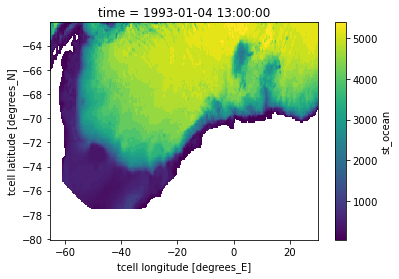

In [44]:
depth_max_salt[0].plot()

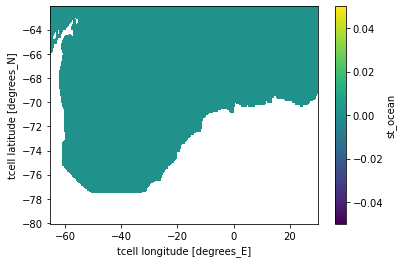

In [45]:
#depth doesn't change in time
depth_max_salt.std(dim='time').plot()

In [46]:
depth_max_salt = depth_max_salt[0]

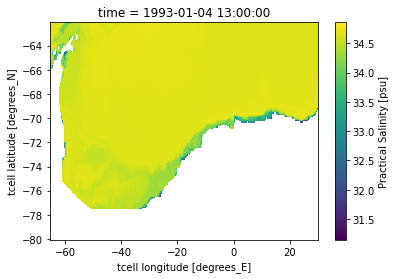

In [47]:
ds_wg.salt[0].sel(st_ocean=depth_max_salt, method='nearest').plot()

In [48]:
salt_mean = ds_wg.salt.mean(dim='time').load()

In [49]:
bottom_salt = salt_mean.sel(st_ocean=depth_max_salt, method='nearest')

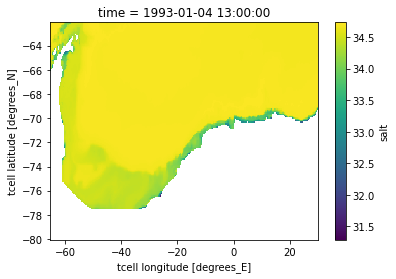

In [50]:
bottom_salt.plot()

In [51]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


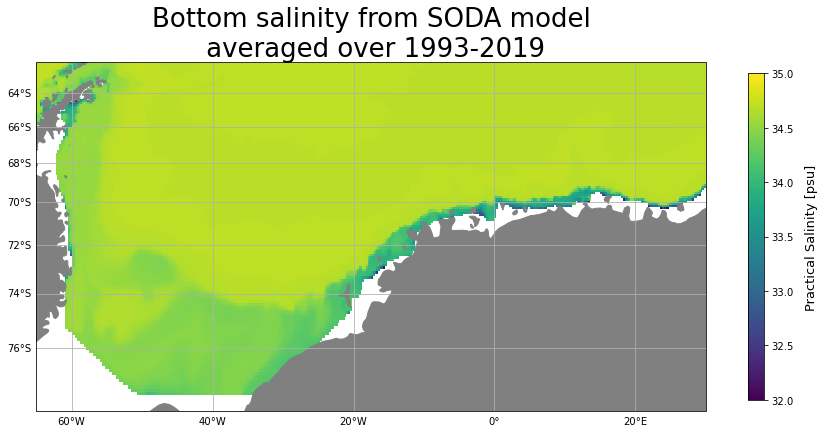

In [52]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_salt, transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SODA model\n averaged over 1993-2019', fontsize=26)
plt.savefig('bot-salt-soda.pdf');

In [53]:
swap_slt = bottom_salt.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [54]:
bottom_salt = swap_slt.assign_coords({"lon": swap_slt.xt_ocean, 'lat':swap_slt.yt_ocean}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

In [55]:
bottom_salt

<xarray.DataArray 'salt' (lat: 169, lon: 381)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [34.7225  , 34.722603, 34.722595, ..., 34.669807, 34.66989 ,
        34.67005 ],
       [34.72252 , 34.722622, 34.721676, ..., 34.669582, 34.669636,
        34.669716],
       [34.72236 , 34.72185 , 34.721813, ..., 34.669323, 34.66924 ,
        34.669094]], dtype=float32)
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [56]:
bottom_salt.to_netcdf('bottom_salt.nc')

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [57]:
salt_std = ds_wg.salt.std(dim='time').load()

In [58]:
bottom_salt_std = salt_std.sel(st_ocean=depth_max_salt, method='nearest')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


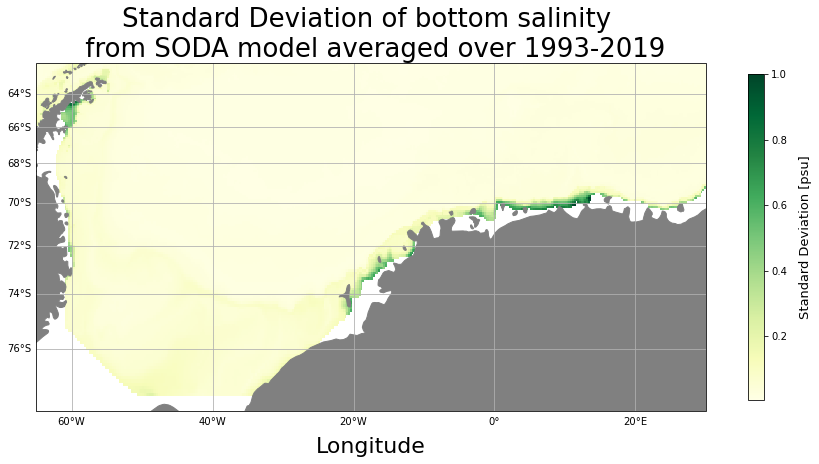

In [64]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_salt_std, transform=ccrs.PlateCarree(), cmap='YlGn', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)

plt.title('Standard Deviation of bottom salinity \n from SODA model averaged over 1993-2019', fontsize=26)
plt.savefig('std-bot-salt-soda.pdf');

In [60]:
swap_dim_slt = bottom_salt_std.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [61]:
bottom_salt_std = swap_dim_slt.assign_coords({"lon": swap_dim_slt.xt_ocean, 
                                              'lat':swap_dim_slt.yt_ocean}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

In [62]:
bottom_salt_std

<xarray.DataArray 'salt' (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01667607, 0.0167114 , 0.016342  , ..., 0.01590053, 0.01613886,
        0.01642593],
       [0.01640019, 0.01632544, 0.01374952, ..., 0.01542513, 0.01547884,
        0.01569463],
       [0.01606008, 0.01450908, 0.01440152, ..., 0.0149381 , 0.01464861,
        0.01431615]], dtype=float32)
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [63]:
bottom_salt_std.to_netcdf('bottom_salt_std.nc')

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)